In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# For reading in csvs and cutting off useless cells
def csv_extractor(state):
    path = 'Demographics/' + state + '_demog.csv'
    df = pd.read_csv(path, encoding='Latin-1')
    df = df.iloc[ : , 0 : 8]
    df = df.loc[df['YEAR'] > 2, : ]
    return df

# Easy peasy csv reading
co_df = csv_extractor('Colorado')
wa_df = csv_extractor('Washington')
ak_df = csv_extractor('Alaska')
or_df = csv_extractor('Oregon')

# CSV containing urban/rural info by county
urban_path = 'Demographics/PctUrbanRural_County.txt'
urban_df = pd.read_csv(urban_path, encoding='Latin-1')

In [3]:
# Function returning only counties within a given range of urban percentages
def urban_slice(df, target_state, high, low):
    
    # The urban_df covers the whole US, need to specify
    state_urban_df = urban_df.loc[urban_df['STATENAME'] == target_state, : ]
    
    # Get number of counties in given state
    unique_counties = df['CTYNAME'].value_counts()[0]
    
    county_list = []
    
    # Build list of urban percentages for main state dataframe
    for i, j in state_urban_df.iterrows():
        county = j[7]
        for k in range(unique_counties):
            county_list.append(county)
    
    # Add urban percentages to main state df, slice by passed boundaries
    df['urban_percent'] = county_list
    df_urban_percent = df.loc[df['urban_percent'] < high, :]
    df_urban_percent = df_urban_percent.loc[df['urban_percent'] > low, :]
    
    return df_urban_percent

In [4]:
# Graph of total population change over 2010-2016 for passed df
def total_graph(df, area):
    
    # AGEGRP 0 is total
    tot = df.loc[df['AGEGRP'] == 0, ]
    
    tot_group_year = tot.groupby('YEAR')
    tot_group_year = tot_group_year.sum()
    tot_group_year.reset_index(inplace=True)
    
    tot_group_year.plot('YEAR', 'TOT_POP', figsize=(18,9))
    
    plt.title(f'Total population of {area}')
    

In [5]:
# Plot of population of passed df sorted by age group
def age_graph(df, area, threshold):
    
    # Age groups as provided by the census bureau
    legend_dict = {0 :'Age 0 to 4 years',
            1 : 'Age 5 to 9 years',
            2 : 'Age 10 to 14 years',
            3 : 'Age 15 to 19 years',
            4 : 'Age 20 to 24 years',
            5 : 'Age 25 to 29 years',
            6 : 'Age 30 to 34 years',
            7 : 'Age 35 to 39 years',
            8 : 'Age 40 to 44 years',
            9 : 'Age 45 to 49 years',
            10 : 'Age 50 to 54 years',
            11 : 'Age 55 to 59 years',
            12 : 'Age 60 to 64 years',
            13 : 'Age 65 to 69 years',
            14 : 'Age 70 to 74 years',
            15 : 'Age 75 to 79 years',
            16 : 'Age 80 to 84 years',
            17 : 'Age 85 years or older'}
    
    # Build list of dataframes, each entry in list is a different age group
    index = [x + 1 for x in range(18)]
    age_list = []
    
    for i in index:
        age = age_df.loc[age_df['AGEGRP'] == i].groupby('YEAR').sum()
        age.reset_index(inplace=True)
        age_list.append(age)
    
    # Init plot
    fig, ax = plt.subplots(figsize=(18,9))
    
    for age in range(len(age_list)):
        
        # Find pop at beginning and end of 2010-2016 for each age group
        begin_pop = age_list[age].get_value(0, 'TOT_POP')
        end_pop = age_list[age].get_value(6, 'TOT_POP')
        
        # Find change in pop for each age group
        diff = abs(end_pop - begin_pop) * 100
        threshcheck = diff / begin_pop
        
        # Compare change in pop to passed threshold, drop age groups that did not change enough to be of interest
        if threshold == None:
            ax.plot(age_list[age]['YEAR'], age_list[age]['TOT_POP'], label=legend_dict[age])
            
        elif threshcheck > threshold:
            ax.plot(age_list[age]['YEAR'], age_list[age]['TOT_POP'], label=legend_dict[age])  
            
    # Plot
    plt.title(f'Population by age in {area}')
    plt.grid()
    plt.legend()


In [6]:
# Plot average age over 2010-2016 in passed df
def avg_age_graph(df):
    
    # Drop AGEGRP 0 because that is total pop
    age_df = df.loc[df['AGEGRP'] > 0, : ]
    
    # Create list of dataframes, each df is a year (3-10 is 2010-2017)
    mean_age_list = []
    
    for i in range(3, 10):
        age = age_df.loc[age_df['YEAR'] == i].groupby('AGEGRP').sum()
        mean_age_list.append(age)
        
    # Create list of dataframes to help calculate avg age
    avg_age_list = []

    for year_data in mean_age_list:
        
        # Population x age for our avg age calculation
        year_data['POP*AGE'] = 0

        year_data.reset_index(inplace=True)
        
        for index, row in year_data.iterrows():
            
            # Use index to produce list of avg ages in each age group (0-4 = 2, 5-9 = 7, etc.)
            age = (2 + (row[0] * 5)) - 5
            
            # Find population x age and add to df
            numerator = row[0] * row[5]            
            year_data.set_value(index, 'POP*AGE', numerator)            
        
        # Calculate avg age for current loop's year
        agg_years = year_data['POP*AGE'].sum()
        tot_pop = year_data['TOT_POP'].sum()
        avg_age = agg_years / tot_pop
        
        # Add average age for the year to list 
        avg_age_list.append(avg_age)
    
    # Convert list of average ages to Pandas series and plot
    avg_age_list = pd.Series(avg_age_list)
    avg_age_list.plot.line()


<h1>Guide</h1>

Currently loaded dataframes : Colorado, Washington, Alaska, Oregon.  <br>
<br>
<big><big><b> Functions: </b></big></big>

<big>Function:  urban_slice </big><br>
Return a slice of the state dataframe only containing counties with a certain "urban percentage".

arguments:  (df, target_state, high, low) <br>
df           =   Name of state's dataframe (e.g. co_df for colorado, ak_df for alaska) <br>
target_state =   State name in the form of a string (e.g. 'Colorado', 'Alaska') <br>
high         =   Upper-boundary of "urban percentage"
low          =   Lower-boundary of "urban percentage"

In [7]:
# Example
example = urban_slice(or_df, 'Oregon', 75, 50)
example.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,urban_percent
38,50,41,1,Oregon,Baker County,3,0,16105,58.99
39,50,41,1,Oregon,Baker County,3,1,852,58.99
40,50,41,1,Oregon,Baker County,3,2,850,58.99
41,50,41,1,Oregon,Baker County,3,3,904,58.99
42,50,41,1,Oregon,Baker County,3,4,978,58.99


<big><big>Function:  total_graph </big></big><br>
Generates a plot of total population over 2010-2016.  Not very useful unless used along with urban_slice.

arguments:  (df, area) <br>
df           =   Name of state's dataframe (e.g. co_df for colorado, ak_df for alaska) <br>
area         =   Name of the area.  This will only appear in the title of the plot and doesn't matter much

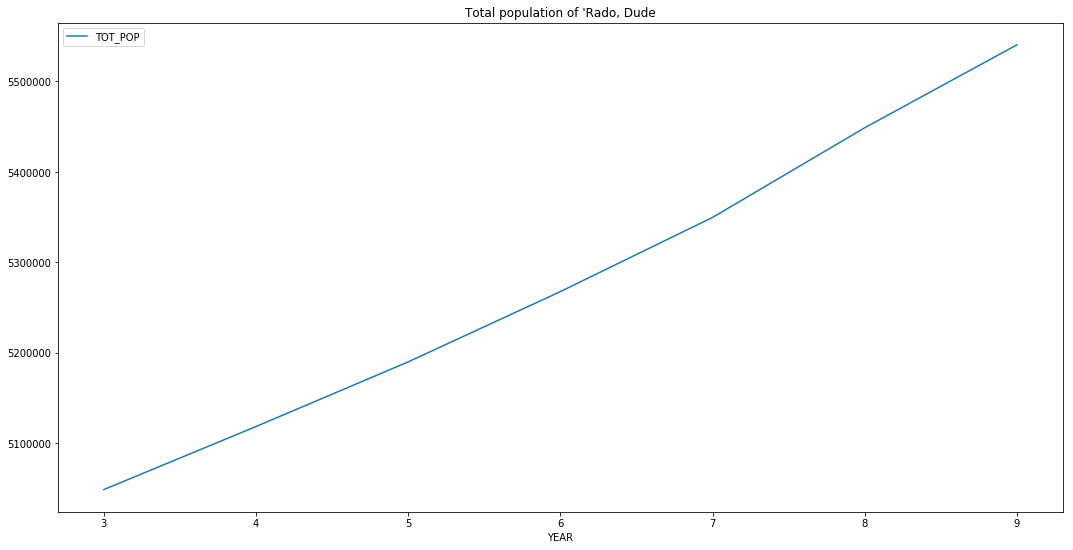

In [8]:
# Example
total_graph(co_df, "'Rado, Dude")

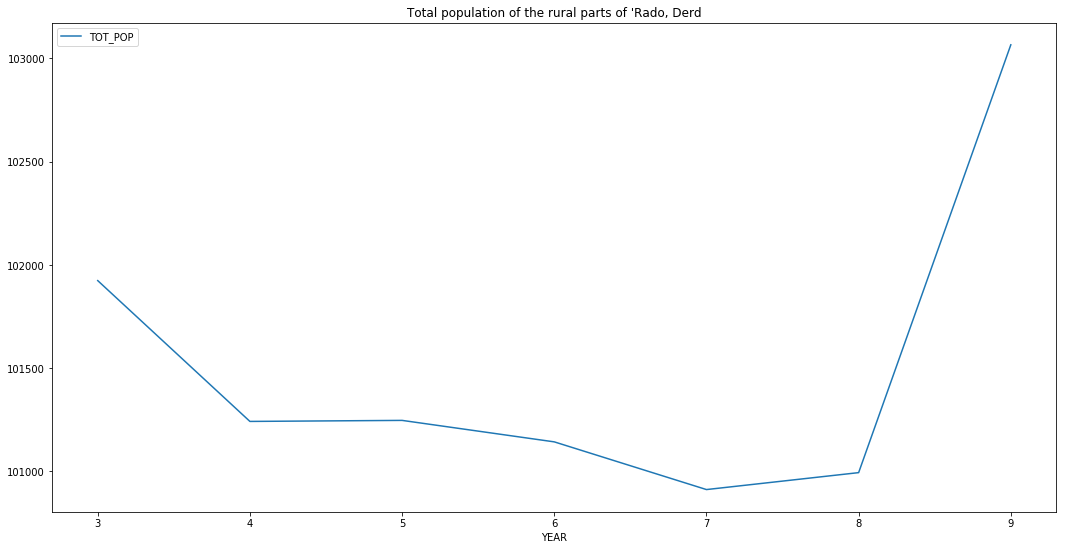

In [9]:
# Much better example
total_graph(urban_slice(co_df, 'Colorado', 40, 20), "the rural parts of 'Rado, Derd")

<big><big>Function:  age_graph </big></big><br>
Generate a plot of population change over 2010-2016, separated by age group.

arguments:  (df, area, threshold) <br>
df           =   Name of state's dataframe (e.g. co_df for colorado, ak_df for alaska) <br>
area         =   Same as the total_graph function. Just for the plot title, doesn't matter much. <br>
threshold    =   This allows you to limit how many lines are drawn on the plot.  If you only want to see lines where the change in population over the 6 years (positive or negative) is %20, you would input 20 here.

In [10]:
# Example
age_graph(ak_df, 'Alaska', 15)

NameError: name 'age_df' is not defined

<big><big>Function:  avg_age_graph </big></big><br>
Generate a plot of average age over 2010-2016.

arguments:  (df, area) <br>
df           =   Name of state's dataframe (e.g. co_df for colorado, ak_df for alaska) <br>


In [ ]:
# Example
avg_age_graph(urban_slice(wa_df, 'Washington', 50, 25))